# JWST Data Analysis Use Case

# NIRCam PSF-matched multiband photometry

## Analyzing simulated NIRCam imaging: JADES JWST GTO extragalactic blank field

http://fenrir.as.arizona.edu/jwstmock/

(Williams et al. 2018)
https://ui.adsabs.harvard.edu/abs/2018ApJS..236...33W

In this example, we use astropy.photutils to detect objects in the simulated F200W image, then measure isophotal photometry in all 9 filters (F090W, F115W, F150W, F200W, F277W, F335M, F356W, F410M, F444W). PSF-matching is required in the long wavelength channel filters, so we degrade F200W to the redder wavelength filters, and perform PSF corrections.

We demonstrate loading the catalog back in and doing some simple analysis of the full catalog and of an individual galaxy. We show the PSF-matching accurately corrects colors on average, and individually for one galaxy, matching the input simulated SED.

Here we analyze only the central 1000 x 1000 pixels (30" x 30") of the full JADES simulation. These cutouts have been staged at STScI with permission from the authors (Williams et al.).

NOTE: The simulated JADES images have different units (e-/s) than JWST pipeline products (MJy/sr).

NOTE: An exposure map is missing but required to calculate flux uncertainties.

# To Do
* Check accuracy of photometry against simulated JADES catalog
* Exposure map required for input to error calculation
* ABmag units cannot be written to ecsv file (astropy update coming soon)
* plot with text labels looks horrible (I wish cursor hover would show id number instead)
* Fix plot secondary axis: mag vs. flux
* requirements.txt file -- but I don't know what versions are "required"
* rest of Robel's comments: https://github.com/spacetelescope/dat_pyinthesky/pull/82#pullrequestreview-355206337

## Import packages

In [1]:
#%matplotlib inline
%matplotlib notebook
import matplotlib.pyplot as plt

import numpy as np
from glob import glob
import os

import astropy
from astropy.io import fits
import astropy.wcs as wcs
from astropy.table import QTable
import astropy.units as u
from astropy.visualization import make_lupton_rgb, SqrtStretch, LogStretch, hist
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma

import photutils
print('photutils', photutils.__version__)
from photutils import Background2D, MedianBackground, detect_sources, deblend_sources, source_properties
from photutils.utils import calc_total_error

from photutils.psf.matching import resize_psf
from photutils import CosineBellWindow, create_matching_kernel
from astropy.convolution import convolve #, Gaussian2DKernel, Tophat2DKernel

photutils 1.0.1


## Create list of images to be loaded and analyzed

In [2]:
baseurl = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/'

filters = 'F090W F115W F150W F200W F277W F335M F356W F410M F444W'.split()

# Data images [e-/s]
image_files = {}
for filt in filters:
    filename = f'jades_jwst_nircam_goods_s_crop_{filt}.fits'
    image_files[filt] = os.path.join(baseurl, filename)

# Weight images (Inverse Variance Maps; IVM)
weight_files = {}
for filt in filters:
    filename = f'jades_jwst_nircam_goods_s_crop_{filt}_wht.fits'
    weight_files[filt] = os.path.join(baseurl, filename)

## Load detection image: F200W

In [3]:
filt = 'F200W'
infile = image_files[filt]
hdu = fits.open(infile)
data = hdu[0].data
imwcs = wcs.WCS(hdu[0].header, hdu)

weight = fits.open(weight_files[filt])[0].data

## Report image size and field of view

In [4]:
ny, nx = data.shape
#pixscale = np.abs(hdu[0].header['CD1_1']) * 3600
pixscale = wcs.utils.proj_plane_pixel_scales(imwcs)[0] 
pixscale *= imwcs.wcs.cunit[0].to('arcsec')
outline = '%d x %d pixels' % (ny, nx)
outline += ' = %g" x %g"' % (ny * pixscale, nx * pixscale)
outline += ' (%.2f" / pixel)' % pixscale
print(outline)

1000 x 1000 pixels = 30" x 30" (0.03" / pixel)


## Create color images (optional)

In [5]:
# 3 NIRCam short wavelength channel images
r = fits.open(image_files['F200W'])[0].data
g = fits.open(image_files['F150W'])[0].data
b = fits.open(image_files['F090W'])[0].data
rgb_sw = make_lupton_rgb(r, g, b, Q=5, stretch=0.02) # , minimum=-0.001

In [6]:
# 3 NIRCam long wavelength channel images
r = fits.open(image_files['F444W'])[0].data
g = fits.open(image_files['F356W'])[0].data
b = fits.open(image_files['F277W'])[0].data

rgb_lw = make_lupton_rgb(r, g, b, Q=5, stretch=0.02) # , minimum=-0.001

<IPython.core.display.Javascript object>


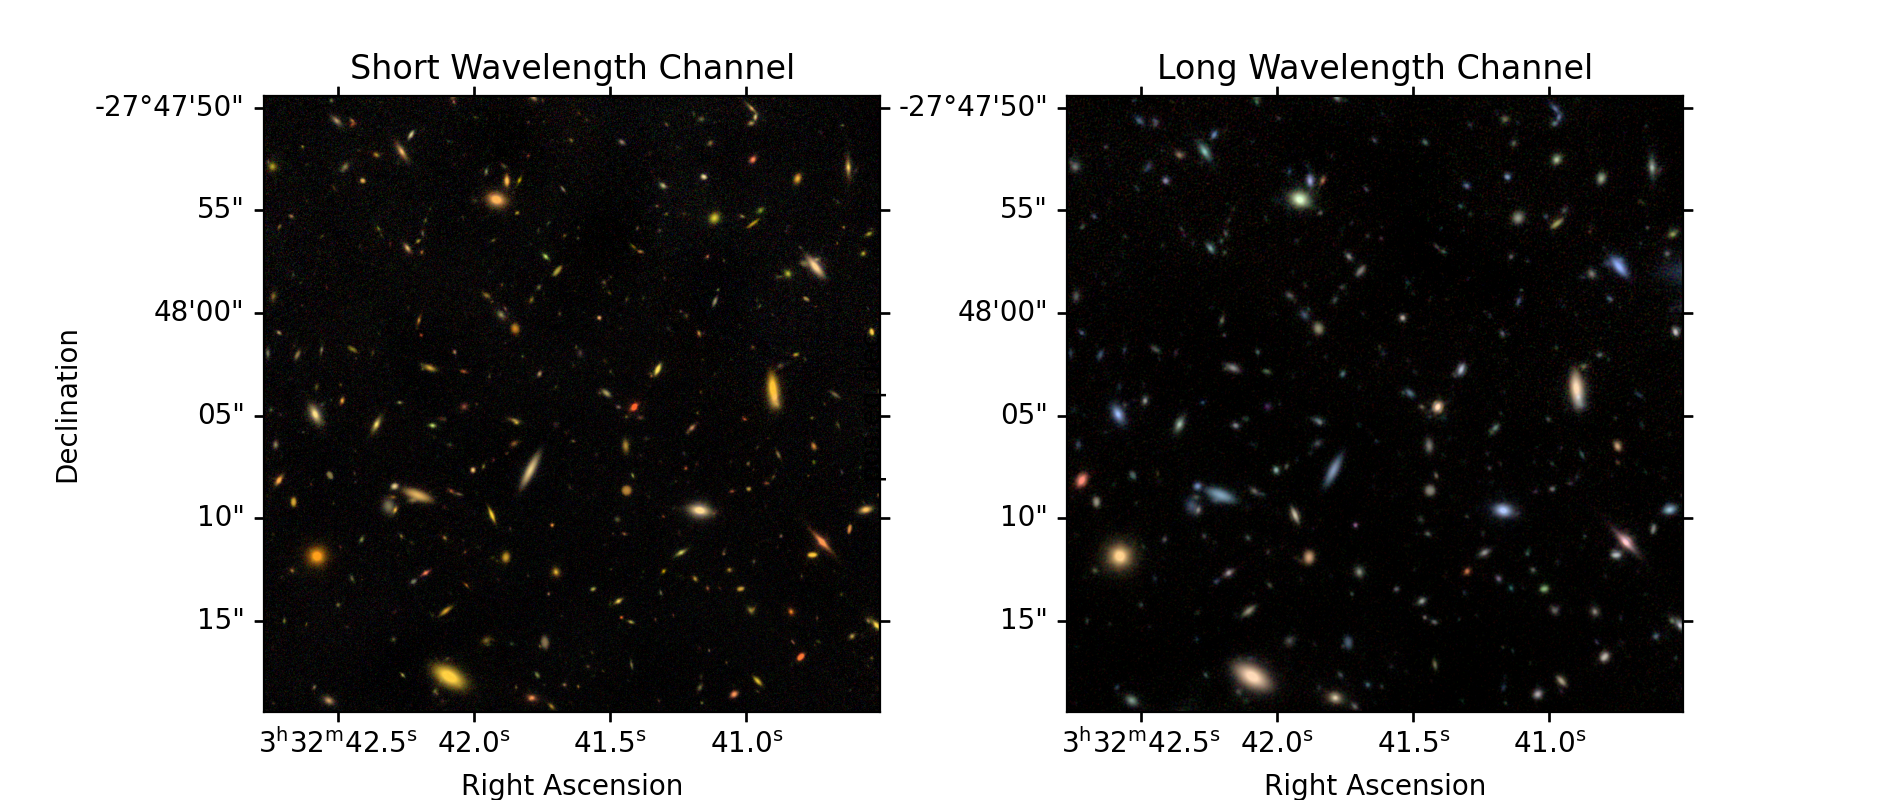

Text(0.5, 1.0, 'Long Wavelength Channel')

In [7]:
fig = plt.figure(figsize=(9.5,4))

ax_sw = fig.add_subplot(1, 2, 1, projection=imwcs)#, sharex=True, sharey=True)
ax_sw.imshow(rgb_sw, origin='lower')
ax_sw.set_xlabel('Right Ascension')
ax_sw.set_ylabel('Declination')
ax_sw.set_title('Short Wavelength Channel')

ax_lw = fig.add_subplot(1, 2, 2, projection=imwcs, sharex=ax_sw, sharey=ax_sw)
ax_lw.imshow(rgb_lw, origin='lower')
ax_lw.set_xlabel('Right Ascension')
ax_lw.set_title('Long Wavelength Channel')
#ax_lw.set(yticklabels=[])  # this didn't work

#plt.subplots_adjust(left=0.15)

## Detect Sources and Deblend using astropy.photutils
https://photutils.readthedocs.io/en/latest/segmentation.html

In [8]:
# For detection, requiring 5 connected pixels 2-sigma above background

# Measure background and set detection threshold
bkg_estimator = MedianBackground()
bkg = Background2D(data, (50, 50), filter_size=(3, 3), bkg_estimator=bkg_estimator)
threshold = bkg.background + (2. * bkg.background_rms)

# Before detection, smooth image with Gaussian FWHM = 3 pixels
sigma = 3.0 * gaussian_fwhm_to_sigma  
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()

# Detect and deblend
segm_detect  = detect_sources(data, threshold, npixels=5, filter_kernel=kernel)
segm_deblend = deblend_sources(data, segm_detect, npixels=5, filter_kernel=kernel, nlevels=32, contrast=0.001)

# Save segmentation map of detected objects
segm_hdu = fits.PrimaryHDU(segm_deblend.data.astype(np.uint32), header=imwcs.to_header())
#segm_hdu.writeto('JADES_detections_segm.fits', overwrite=True)

## Measure photometry (and more) in detection image
https://photutils.readthedocs.io/en/latest/segmentation.html#centroids-photometry-and-morphological-properties

In [9]:
#error = bkg.background_rms
# Input weight should be exposure map. Fudging for now.
error = calc_total_error(data, bkg.background_rms, weight/500)  # fudge
cat = source_properties(data-bkg.background, segm_deblend, wcs=imwcs, background=bkg.background, error=error)

## Show detections alongside images (optional)

<IPython.core.display.Javascript object>


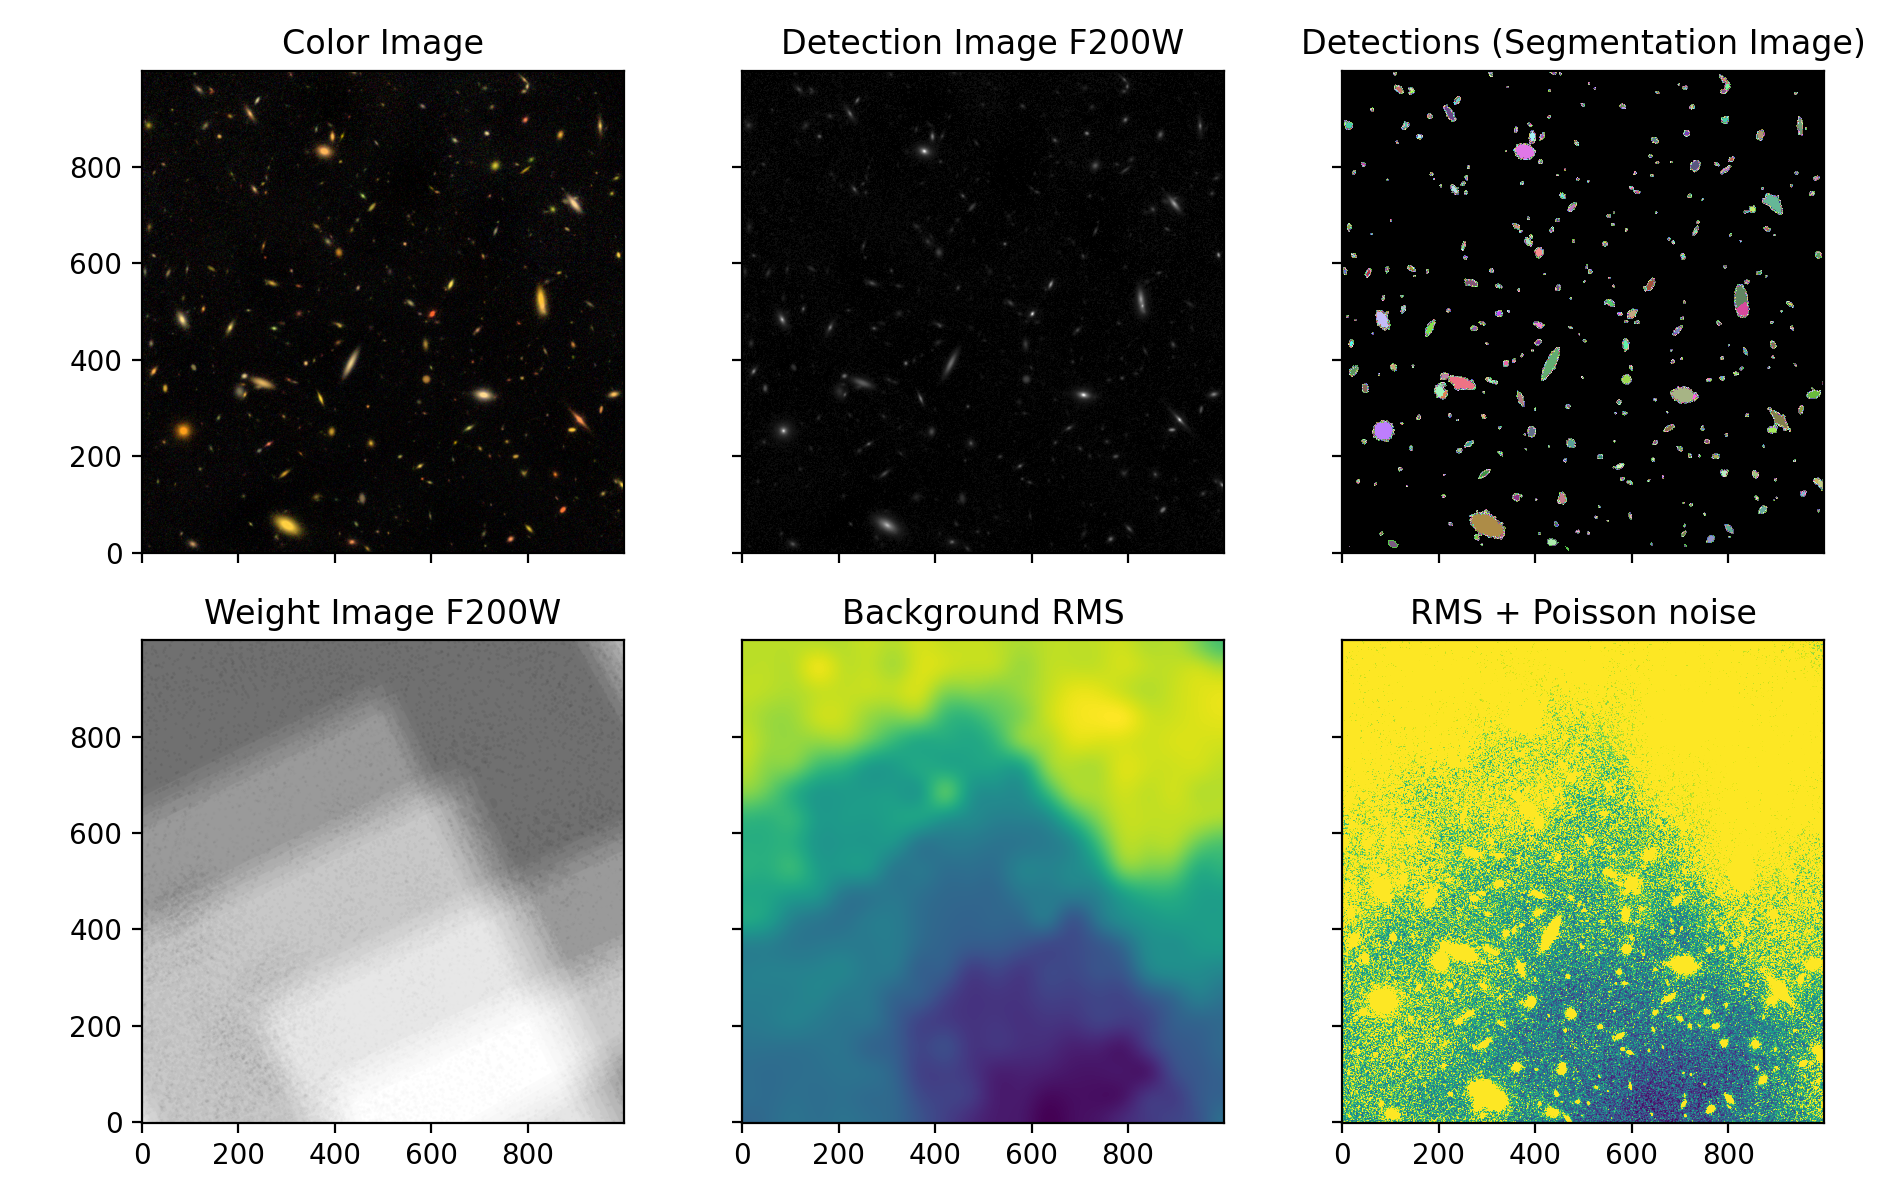

<ipython-input-10-96aed2e65372>:10: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax[0,1].imshow(data, origin='lower', cmap='Greys_r', norm=norm, vmin=0)


In [10]:
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(9.5,6))
# For RA,Dec axes instead of pixels, add: , subplot_kw={'projection': imwcs})

# Color image
ax[0,0].imshow(rgb_sw, origin='lower')
ax[0,0].set_title('Color Image')

# Data
norm = ImageNormalize(stretch=SqrtStretch())
ax[0,1].imshow(data, origin='lower', cmap='Greys_r', norm=norm, vmin=0)
ax[0,1].set_title('Detection Image F200W')

# Segmentation map
cmap = segm_deblend.make_cmap(seed=12345)  # ERROR
ax[0,2].imshow(segm_deblend, origin='lower', cmap=cmap)
ax[0,2].set_title('Detections (Segmentation Image)')

# Weight
#norm = ImageNormalize(stretch=SqrtStretch())
ax[1,0].imshow(weight, origin='lower', cmap='Greys_r', vmin=0)
ax[1,0].set_title('Weight Image F200W')

# RMS
norm = ImageNormalize()
ax[1,1].imshow(bkg.background_rms, origin='lower', norm=norm)
ax[1,1].set_title('Background RMS')

# Total error including Poisson noise
ax[1,2].imshow(error, origin='lower', norm=norm)
ax[1,2].set_title('RMS + Poisson noise')

fig.tight_layout()

## View all measured quantities in detection image (optional)

In [11]:
#cat.to_table()

## Only keep some quantities

In [12]:
columns = 'id xcentroid ycentroid sky_centroid area semimajor_axis_sigma semiminor_axis_sigma ellipticity orientation gini'.split()
tbl = cat.to_table(columns=columns)
tbl.rename_column('semimajor_axis_sigma', 'a')
tbl.rename_column('semiminor_axis_sigma', 'b')

In [13]:
#tbl

## Convert measured fluxes (data units) to magnitudes

https://docs.astropy.org/en/stable/units/

https://docs.astropy.org/en/stable/units/equivalencies.html#photometric-zero-point-equivalency

https://docs.astropy.org/en/stable/units/logarithmic_units.html#logarithmic-units

In [14]:
# not detected: mag =  99; magerr = 1-sigma upper limit assuming zero flux
# not observed: mag = -99; magerr = 0
def fluxes2mags(flux, fluxerr):
    nondet = flux < 0  # Non-detection if flux is negative
    unobs = (fluxerr <= 0) + (fluxerr == np.inf)  # Unobserved if flux uncertainty is negative or infinity

    mag = flux.to(u.ABmag)
    magupperlimit = fluxerr.to(u.ABmag) # 1-sigma upper limit if flux=0

    mag = np.where(nondet, 99 * u.ABmag, mag)
    mag = np.where(unobs, -99 * u.ABmag, mag)

    magerr = 2.5 * np.log10(1 + fluxerr/flux) 
    magerr = magerr.value * u.ABmag

    magerr = np.where(nondet, magupperlimit, magerr)
    magerr = np.where(unobs, 0*u.ABmag, magerr)
    
    return mag, magerr

# Includes features I couldn't find in astropy:
# mag = 99 / -99 for non-detections / unobserved
# flux uncertainties -> mag uncertainties

## Multiband photometry using isophotal apertures defined in detection image
(Similar to running SourceExtractor in double-image mode)  
(No PSF corrections just yet)

In [15]:
filters = 'F090W F115W F150W F200W F277W F335M F356W F410M F444W'.split()
for filt in filters:
    infile = image_files[filt]
    print(filt)
    print(infile)
    print(weight_files[filt])
    hdu = fits.open(infile)
    data = hdu[0].data
    zp = hdu[0].header['ABMAG'] * u.ABmag  # zeropoint
    weight = fits.open(weight_files[filt])[0].data
    
    # Measure background
    bkg = Background2D(data, (50, 50), filter_size=(3, 3), bkg_estimator=bkg_estimator)
    #error = bkg.background_rms
    error = calc_total_error(data, bkg.background_rms, weight/500) # fudge
                             
    # Measure properties in each image of previously detected objects 
    filtcat = source_properties(data-bkg.background, segm_deblend, wcs=imwcs, background=bkg.background, error=error)

    # Convert measured fluxes to fluxes in nJy and to AB magnitudes
    filttbl = filtcat.to_table()
    tbl[filt+'_flux']    = flux    = filttbl['source_sum']     * zp.to(u.nJy)
    tbl[filt+'_fluxerr'] = fluxerr = filttbl['source_sum_err'] * zp.to(u.nJy)

    mag, magerr = fluxes2mags(flux, fluxerr)
    #mag = mag * u.ABmag  # incompatible with file writing
    tbl[filt+'_mag']    = mag.value
    tbl[filt+'_magerr'] = magerr.value

F090W
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F090W.fits
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F090W_wht.fits
F115W
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F115W.fits
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F115W_wht.fits
F150W
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F150W.fits
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F150W_wht.fits
F200W
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F200W.fits
https://data.science.stsci.edu/redirect/JWST/jwst-data

## View complete results (optional)

In [16]:
#tbl

## Save photometry as output catalog

In [17]:
#tbl.write('JADESphotometry.ecsv', overwrite=True)

In [18]:
#!cat JADESphotometry.ecsv

## Load PSFs

First, download and unpack the tar files available here:  
https://jwst-docs.stsci.edu/near-infrared-camera/nircam-predicted-performance/nircam-point-spread-functions#NIRCamPointSpreadFunctions-SimulatedNIRCamPSFs  
PSFs_SW_filters: https://stsci.box.com/s/s2lepxr9086gq4sogr3kwftp54n1c5vl  
PSFs_LW_filters: https://stsci.box.com/s/gzl7blxb1k3p4n66gs7jvt7xorfrotyb  
Each FITS file contains:  
– hdu[0]: a 4x oversampled PSF  
– hdu[1]: PSF at detector pixel scale (0.031" and 0.063" in the short and long wavelength channels, respectively)

In [19]:
PSF_inputs = {}
PSF_images = {}

image_pixel_scale = pixscale  # 0.03" / pix
detector_pixel_scales = {'SW':0.031, 'LW':0.063}

for i, filt in enumerate(filters):
    lam = int(filt[1:4]) / 100
    if lam < 2.4:
        channel = 'SW'
    else:
        channel = 'LW'

    # Load PSF
    PSFdir = 'NIRCam_PSFs_' + channel
    PSFfile = 'PSF_%scen_G5V_fov299px_ISIM41.fits' % filt
    PSFfile = os.path.join(PSFdir, PSFfile)
    PSF_hdu = fits.open(PSFfile)
    PSF_inputs[filt] = data = PSF_hdu[1].data  # 2nd extension is at pixel scale (not oversampled)
    #imwcs = wcs.WCS(hdu[0].header, hdu)
    ny, nx = data.shape
    
    # Resize from detector pixel scale to image pixel scale (here 0.03" / pix)
    detector_pixel_scale = detector_pixel_scales[channel]
    ny_resize = ny * detector_pixel_scale / image_pixel_scale  # Assume square PSF (ny = nx)
    ny_resize = np.round(ny_resize)
    ny_resize = np.int((ny_resize // 2) * 2 + 1)  # Make it an odd number of pixels to ensure PSF is centered
    PSF_pixel_scale = ny_resize / ny * image_pixel_scale    
    PSF_image = resize_psf(PSF_inputs[filt], PSF_pixel_scale, image_pixel_scale)  # Resize PSF here
    r = (ny_resize - ny) // 2
    PSF_images[filt] = PSF = PSF_image[r:-r,r:-r]  # Trim to same size as input PSFs
    #print(filt, ny, ny_resize, PSF_image.shape, PSF_images[filt].shape, PSF_pixel_scale)

# PSF Matching 

https://photutils.readthedocs.io/en/stable/psf_matching.html

## Determine PSF convolution kernels

<IPython.core.display.Javascript object>


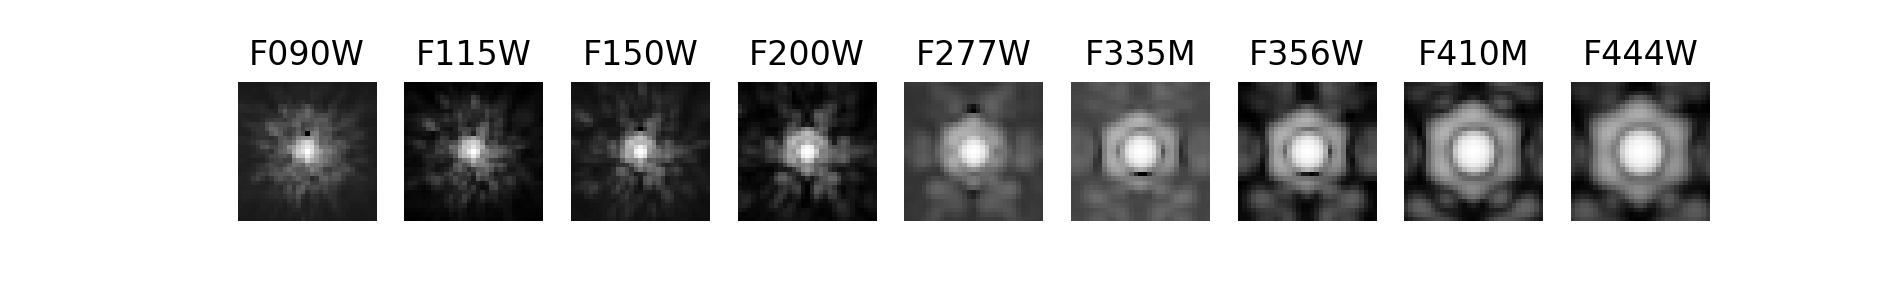

In [20]:
# Show PSFs (optional)

fig, ax = plt.subplots(1, len(filters), figsize=(9.5,1.5), sharex=True, sharey=True)

r = 15
for i, filt in enumerate(filters):
    data = PSF_images[filt]
    ny, nx = data.shape
    yc = ny // 2
    xc = nx // 2
    stamp = data[yc-r:yc+r+1, xc-r:xc+r+1]
    norm = ImageNormalize(stretch=LogStretch())  # scale each filter individually
    ax[i].imshow(stamp, cmap='Greys_r', norm=norm, origin='lower')
    ax[i].set_title(filt.upper())
    ax[i].axis('off')

In [21]:
PSF_kernels = {}
reference_filter = 'F200W'
reference_PSF = PSF_images[reference_filter]
i_reference = filters.index(reference_filter)
window = CosineBellWindow(alpha=0.35)
for filt in filters[i_reference+1:]:
    PSF_kernels[filt] = PSF_matching_kernel = create_matching_kernel(reference_PSF, PSF_images[filt], window=window)

## Convolve PSFs and compare to actual (optional)

In [22]:
PSFs_convolved = {}
for filt in filters[i_reference+1:]:
    PSF = PSF_images[reference_filter][yc-r:yc+r+1, xc-r:xc+r+1]
    kernel = PSF_kernels[filt][yc-r:yc+r+1, xc-r:xc+r+1]
    PSFs_convolved[filt] = convolve(PSF, kernel)    

In [23]:
def radial_profile(PSF):
    data = PSF
    ny, nx = data.shape
    yc = ny // 2
    xc = nx // 2
    y, x = np.indices(data.shape)
    rr = np.sqrt((x-xc)**2 + (y-yc)**2)
    ii = np.argsort(rr.flat)
    rr = rr.flat[ii]
    yy = data.flat[ii]
    return rr, yy

<IPython.core.display.Javascript object>


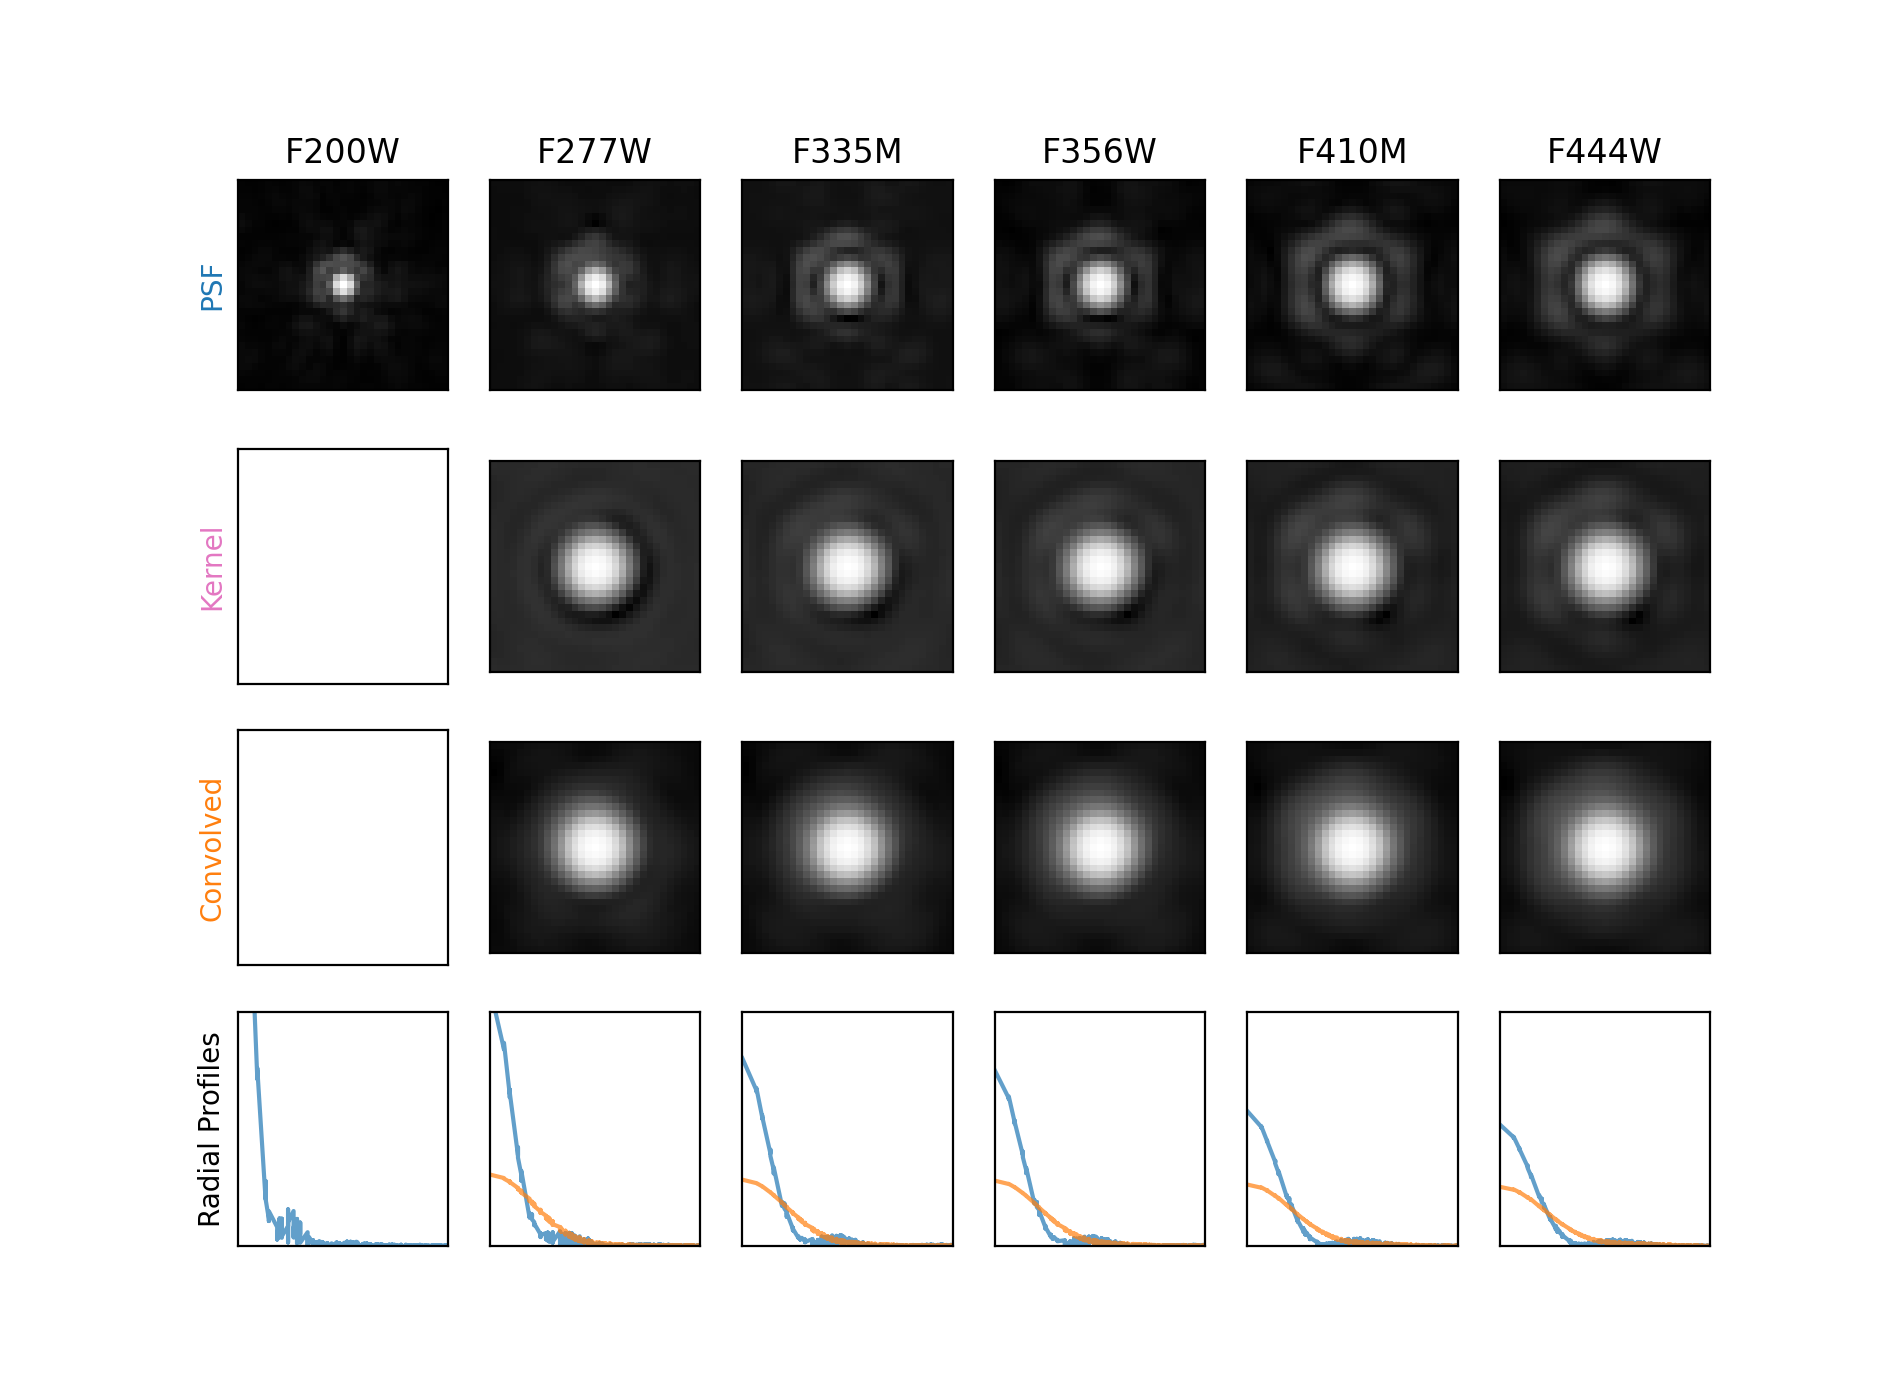

Text(0, 0.5, 'Radial Profiles')

In [24]:
mpl_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_colors = [mpl_colors[i] for i in (0,6,1)]

plot_filters = filters[i_reference:]
ncolumns = len(plot_filters)

fig, ax = plt.subplots(4, ncolumns, figsize=(9.5,7))#, sharex=True, sharey=True)

for i, filt in enumerate(plot_filters):
    # Input PSF on top row
    ny, nx = PSF_images[filt].shape
    yc = ny // 2
    xc = nx // 2    
    stamp = PSF_images[filt][yc-r:yc+r+1, xc-r:xc+r+1]
    norm = ImageNormalize(stretch=SqrtStretch())  # scale each stamp individually
    ax[0,i].imshow(stamp, cmap='Greys_r', norm=norm, origin='lower')
    ax[0,i].set_title(filt.upper())

    rr, yy = radial_profile(stamp)
    ax[3,i].plot(rr, yy, color=plot_colors[0], alpha=0.7)
    ax[3,i].set_xlim(0,r)
    ax[3,i].set_ylim(0,0.05)

    for j in range(4):
        ax[j,i].get_xaxis().set_ticks([])
        ax[j,i].get_yaxis().set_ticks([])

    if i == 0:
        # Plot F200W profile everywhere for comparison
        for icolumn in range(ncolumns):
            ax[3,icolumn].plot(rr, yy, color='g', lw=0) # hidden with lw=0
        continue
        
    # Kernels
    kernel = PSF_kernels[filt][yc-r:yc+r+1, xc-r:xc+r+1]
    norm = ImageNormalize(stretch=SqrtStretch())  # scale each stamp individually
    ax[1,i].imshow(kernel, cmap='Greys_r', norm=norm, origin='lower')
    
    rr, yy = radial_profile(kernel)
    ax[3,i].plot(rr, yy, color=plot_colors[1], alpha=0.7, lw=0) # hidden with lw=0

    # Convolved PSFs
    stamp = PSFs_convolved[filt]
    norm = ImageNormalize(stretch=SqrtStretch())  # scale each stamp individually
    ax[2,i].imshow(stamp, cmap='Greys_r', norm=norm, origin='lower')

    rr, yy = radial_profile(stamp)
    ax[3,i].plot(rr, yy, color=plot_colors[2], alpha=0.7)

ax[0,0].set_ylabel('PSF', color=plot_colors[0])
ax[1,0].set_ylabel('Kernel', color=plot_colors[1])
ax[2,0].set_ylabel('Convolved', color=plot_colors[2])
ax[3,0].set_ylabel('Radial Profiles')

## Convolve F200W detection image to Long Wavelength PSFs

In [25]:
reference_image_hdu = fits.open(image_files[reference_filter])
reference_image_data = reference_image_hdu[0].data[:]

for filt in filters[i_reference+1:]:
    output_filter = filt
    output_image = 'jades_convolved_%s_to_%s.fits' % (reference_filter, output_filter)
    if os.path.exists(output_image):
        print(output_image, 'EXISTS')
    else:
        print(output_filter + '...')
        PSF_kernel = PSF_kernels[filt][yc-r:yc+r+1, xc-r:xc+r+1]
        convolved_image = convolve(reference_image_data, PSF_kernel)
        reference_image_hdu[0].data = convolved_image
        print('SAVING %s' % output_image)
        reference_image_hdu.writeto(output_image)

jades_convolved_F200W_to_F277W.fits EXISTS
jades_convolved_F200W_to_F335M.fits EXISTS
jades_convolved_F200W_to_F356W.fits EXISTS
jades_convolved_F200W_to_F410M.fits EXISTS
jades_convolved_F200W_to_F444W.fits EXISTS


## Multiband photometry in convolved images 

In [26]:
for filt in filters[i_reference+1:]:
    infile = 'jades_convolved_%s_to_%s.fits' % (reference_filter, output_filter)
    print(filt)
    print(infile)
    print(weight_files[filt])
    hdu = fits.open(infile)
    data = hdu[0].data
    zp = hdu[0].header['ABMAG'] * u.ABmag  # zeropoint
    weight = fits.open(weight_files[filt])[0].data
    
    # Measure background
    bkg = Background2D(data, (50, 50), filter_size=(3, 3), bkg_estimator=bkg_estimator)
    #error = bkg.background_rms
    error = calc_total_error(data, bkg.background_rms, weight/500)  # 500 fudge
    # Should handle uncertainties better! (also for regular images...)
                             
    # Measure properties in each image of previously detected objects 
    filtcat = source_properties(data-bkg.background, segm_deblend, wcs=imwcs, background=bkg.background, error=error)

    # Convert measured fluxes to fluxes in nJy and to AB magnitudes
    filttbl = filtcat.to_table()
    tbl['convolved_to_'+filt+'_flux']    = flux    = filttbl['source_sum']     * zp.to(u.nJy)
    tbl['convolved_to_'+filt+'_fluxerr'] = fluxerr = filttbl['source_sum_err'] * zp.to(u.nJy)

    mag, magerr = fluxes2mags(flux, fluxerr)
    #mag = mag * u.ABmag  # incompatible with file writing
    tbl['convolved_to_'+filt+'_mag']    = mag.value
    tbl['convolved_to_'+filt+'_magerr'] = magerr.value

F277W
jades_convolved_F200W_to_F444W.fits
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F277W_wht.fits
F335M
jades_convolved_F200W_to_F444W.fits
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F335M_wht.fits
F356W
jades_convolved_F200W_to_F444W.fits
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F356W_wht.fits
F410M
jades_convolved_F200W_to_F444W.fits
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F410M_wht.fits
F444W
jades_convolved_F200W_to_F444W.fits
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F444W_wht.fits


In [27]:
#tbl

# Magnitude corrections

In [28]:
from copy import deepcopy
tbl_without_corrections = deepcopy(tbl)

In [29]:
# Correct magnitudes in place (so only run this cell once!)
# mag_corrected = mag + det_mag - det_blurry_mag

for filt in filters[i_reference+1:]:
    reference_magnitudes = tbl[reference_filter+'_mag']
    blurred_magnitudes = tbl['convolved_to_'+filt+'_mag']
    magnitude_corrections = reference_magnitudes - blurred_magnitudes
    filter_magnitudes = tbl[filt+'_mag']
    corrected_magnitudes = filter_magnitudes + magnitude_corrections
    good_magnitudes = np.less(filter_magnitudes, 90) * np.greater(filter_magnitudes, 0)
    corrected_magnitudes = np.where(good_magnitudes, corrected_magnitudes, filter_magnitudes)

    reference_fluxes = tbl[reference_filter+'_flux']
    flux_corrections = 10 ** (-0.4 * magnitude_corrections)
    flux_corrections = np.where(good_magnitudes, flux_corrections, 1)
    filter_fluxes = tbl[filt+'_flux']
    corrected_fluxes = filter_fluxes * flux_corrections

    tbl[filt+'_flux'] = corrected_fluxes     # Upddating in place! (so only run this once)
    tbl[filt+'_mag'] = corrected_magnitudes  # Upddating in place! (so only run this once)
    tbl[filt+'_flux_PSFcor'] = flux_corrections
    tbl[filt+'_mag_PSFcor']  = magnitude_corrections

## Reformat output catalog for readability (optional)

In [30]:
# Remove units (pixels) from area
tbl['area'] = tbl['area'].value.astype(int)

# Replace sky_centroid with ra, dec
tbl['ra'] = tbl['sky_centroid'].ra.degree
tbl['dec'] = tbl['sky_centroid'].dec.degree

columns = list(tbl.columns)
columns = columns[:3] + ['ra', 'dec'] + columns[4:-2]

for i, column in enumerate(columns):
    if column.endswith('flux'):
        break

columns = columns[:i]

for filt in filters:
    columns.append(filt+'_flux')
    columns.append(filt+'_fluxerr')
    columns.append(filt+'_mag')
    columns.append(filt+'_magerr')
    #column = filt+'_flux_PSF-correction'
    column = filt+'_flux_PSFcor'
    if column in list(tbl.columns):
        columns.append(column)
        columns.append(filt+'_mag_PSFcor')
        
tbl = tbl[columns]

for column in columns:
    tbl[column].info.format = '.4f'

tbl['ra'].info.format = '11.7f'
tbl['dec'].info.format = ' 11.7f'

tbl['id'].info.format = 'd'
tbl['area'].info.format = 'd'

In [31]:
tbl.write('JADES_photometry.ecsv', overwrite=True)

In [32]:
tbl.write('JADES_photometry.cat', format='ascii.fixed_width_two_line', delimiter=' ', overwrite=True)

In [33]:
#!cat JADES_photometry.cat

# Start new session and analyze results

## Load catalog and segmentation map

In [34]:
# Catalog: ecsv format preserves units for loading in Python notebooks
tbl = QTable.read('JADES_photometry.ecsv')

# Reconstitute filter list
filters = []
for param in tbl.columns:
    if param[-4:] == '_mag':
        filters.append(param[:-4])

In [35]:
# Segmentation map
segmfile = 'JADES_detections_segm.fits'
segm = fits.open(segmfile)[0].data
segm = photutils.segmentation.SegmentationImage(segm)

# Input simulation JADES JAGUAR catalog

In [36]:
from astropy.table import Table
infile = 'JADES_SF_mock_r1_v1.1.fits.gz'
simcat = Table.read(infile)

RArange  = 53.16879, 53.1782
DECrange = -27.805394, -27.797069

good1 = simcat['RA'] > RArange[0]
good2 = simcat['RA'] < RArange[1]
good3 = simcat['DEC'] > DECrange[0]
good4 = simcat['DEC'] < DECrange[1]
allgood = good1 * good2 * good3 * good4

simcropcat = simcat[allgood]

In [37]:
# Match objects to photutils catalog
# https://docs.astropy.org/en/stable/coordinates/matchsep.html
from astropy.coordinates import SkyCoord
from astropy import units as u
coordsim = SkyCoord(ra=simcropcat['RA']*u.degree, dec=simcropcat['DEC']*u.degree)
#coorddet = tbl['sky_centroid']  # Photutils detection catalog
coorddet = SkyCoord(ra=tbl['ra']*u.degree, dec=tbl['dec']*u.degree)
#idx, d2d, d3d = coordsim.match_to_catalog_sky(coorddet)
idx, d2d, d3d = coorddet.match_to_catalog_sky(coordsim)  # Match photutils to input catalog

# Only keep close matches
d = d2d / u.degree * 3600  # arcsec
goodmatch = d < 0.036

simid = simcropcat[idx]['ID']
simid = np.where(goodmatch, simid, -1)

zsim = simcropcat[idx]['redshift']
zsim = np.where(goodmatch, zsim, -1)

#magtbl['simid'] = simid
#magtbl['matchdist'] = d
#magtbl['zsim'] = zsim
#magtbl.write('JADEScropz.cat', format='ascii.fixed_width_two_line', delimiter=' ', overwrite=True)

# Color-Magnitude Diagram

<IPython.core.display.Javascript object>


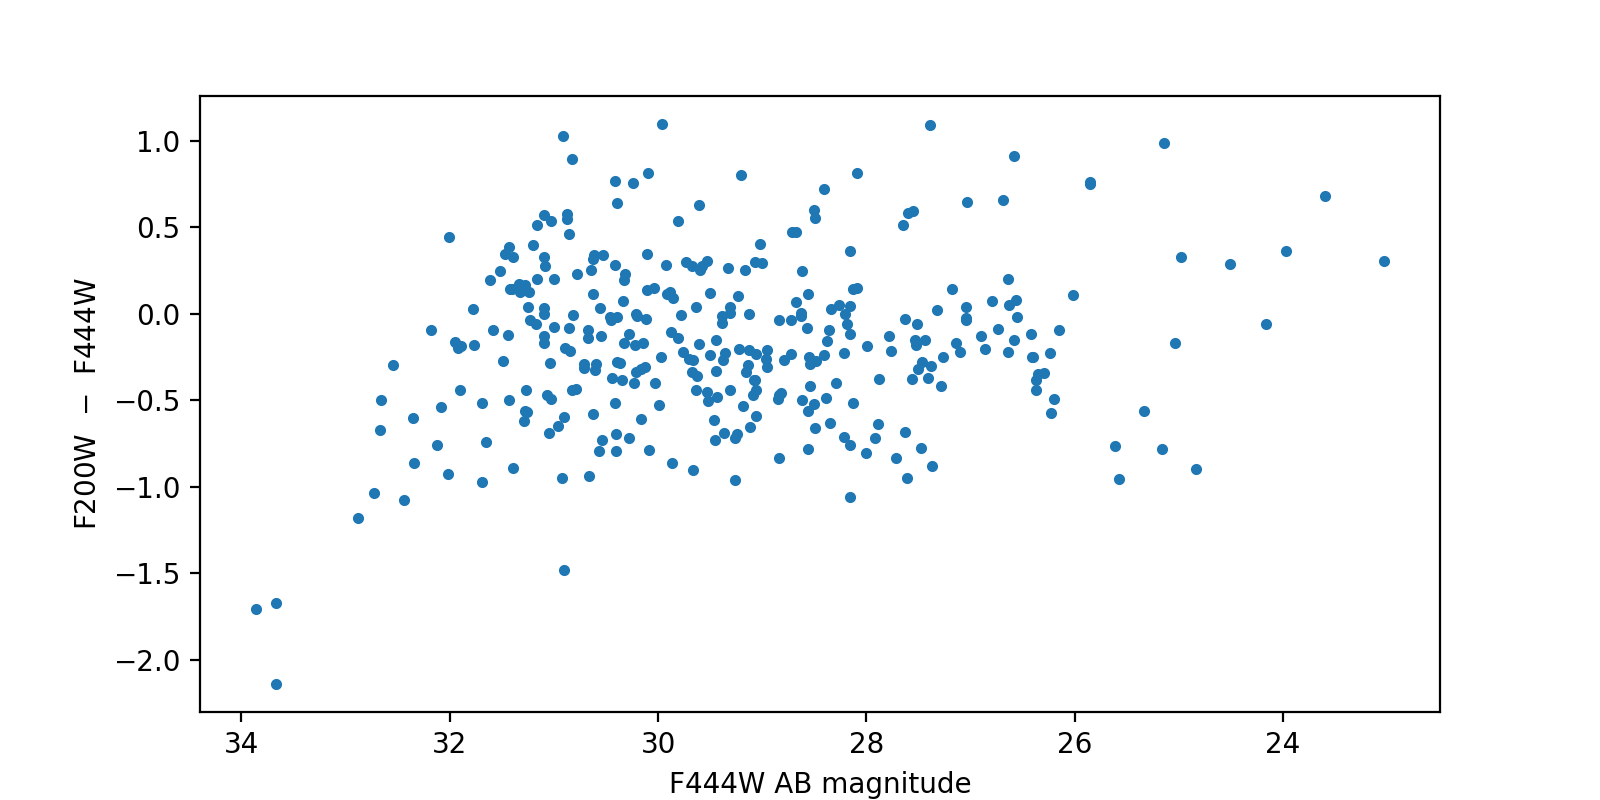

Text(0, 0.5, 'F200W  $-$  F444W')

In [38]:
#import mplcursors
# Would love a better solution here!

filt1, filt2 = 'F200W F444W'.split()

mag1 = tbl[filt1+'_mag']
mag2 = tbl[filt2+'_mag']

# Only plot detections
det1 = (0 < mag1) & (mag1 < 90)
det2 = (0 < mag2) & (mag2 < 90)
det = det1 * det2

mag1 = mag1[det]
mag2 = mag2[det]

plt.figure(figsize=(8,4))

plt.plot(mag2, mag1-mag2, '.')

plt.xlim(plt.xlim()[::-1])

plt.xlabel(filt2 + ' AB magnitude')
plt.ylabel(filt1 + '  $-$  ' + filt2)

<IPython.core.display.Javascript object>


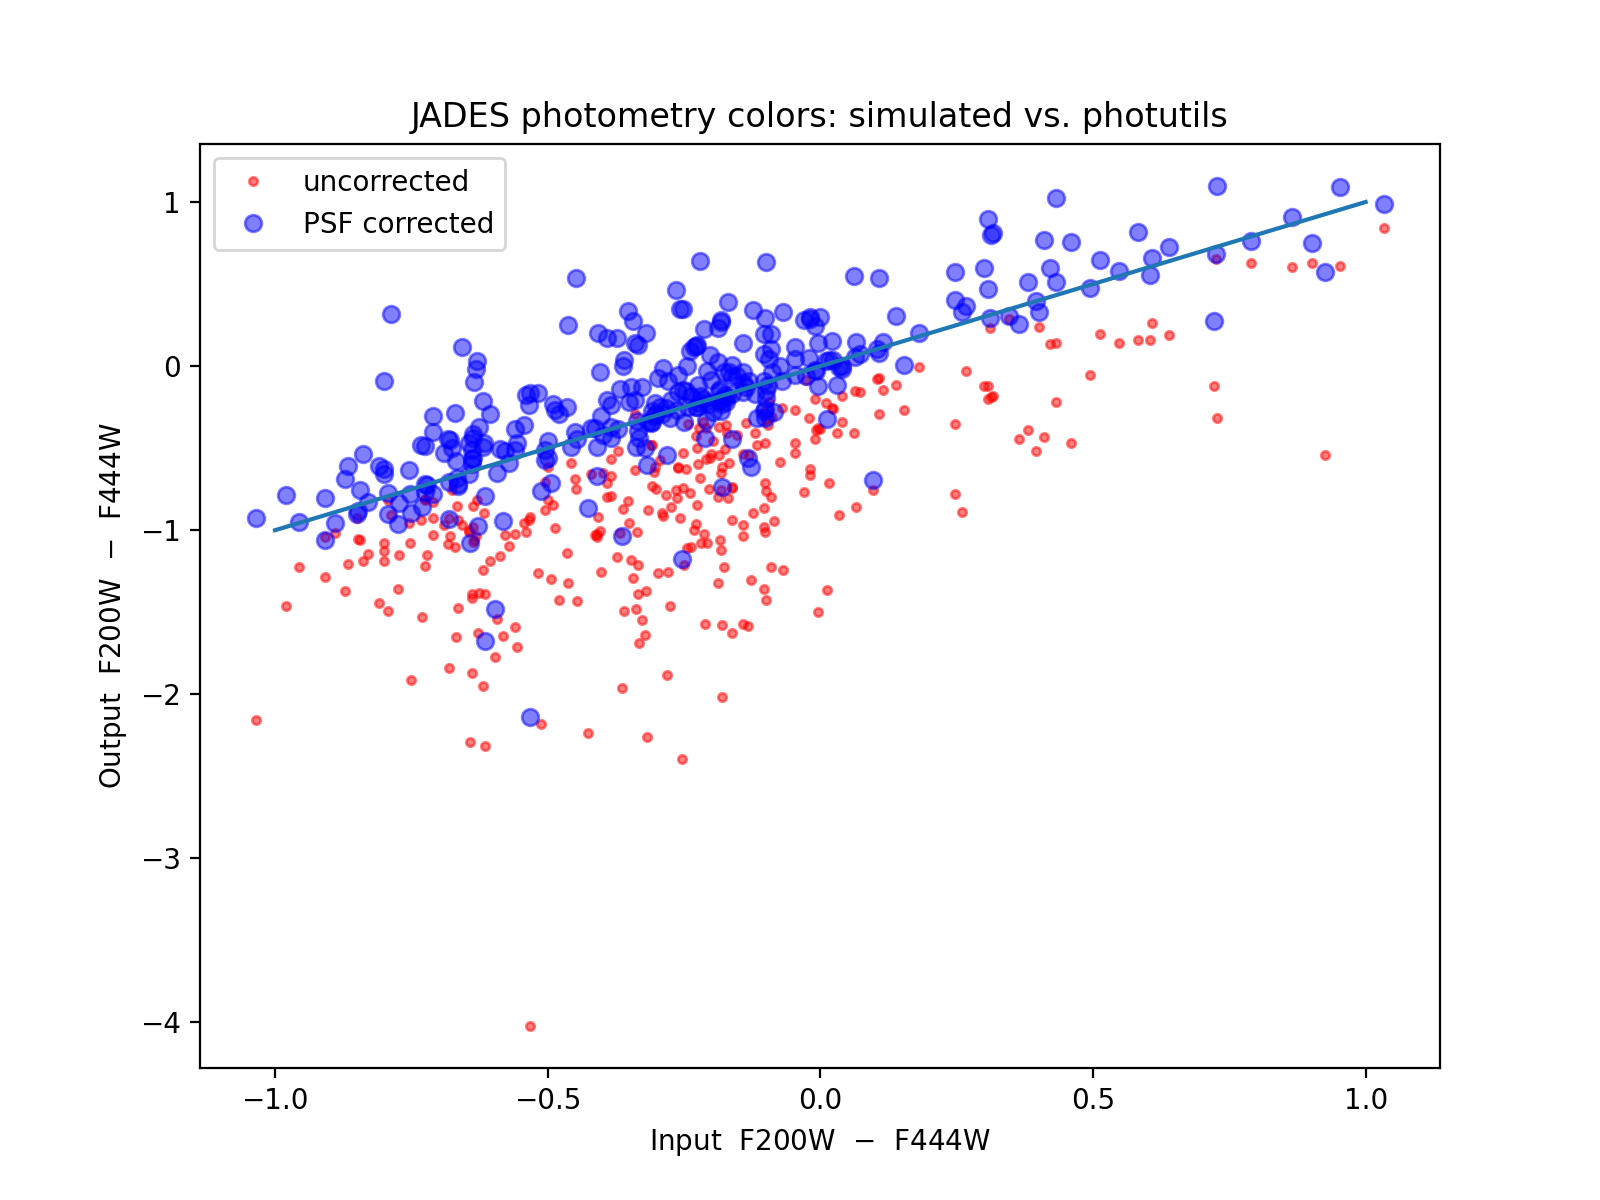

In [39]:
# Input vs. Output Color

filt1, filt2 = 'F200W F444W'.split()
#filt1, filt2 = 'F115W F200W'.split()
#filt1, filt2 = 'F277W F444W'.split()
#filt1, filt2 = 'F200W F277W'.split()

input_flux1  = simcropcat['NRC_%s_fnu'%filt1][idx][goodmatch]
input_flux2  = simcropcat['NRC_%s_fnu'%filt2][idx][goodmatch]

input_mag1 = (input_flux1 * u.nJy).to(u.ABmag).value
input_mag2 = (input_flux2 * u.nJy).to(u.ABmag).value


output_mag1 = tbl[filt1+'_mag'][goodmatch]
output_mag2 = tbl[filt2+'_mag'][goodmatch]

# Only plot detections
det1 = (0 < output_mag1) & (output_mag1 < 90)
det2 = (0 < output_mag2) & (output_mag2 < 90)
det = det1 * det2

output_mag1 = output_mag1[det]
output_mag2 = output_mag2[det]

input_color  = input_mag1  - input_mag2
output_color = output_mag1 - output_mag2

output_mag1_uncor = output_mag1 #- tbl[filt1+'_mag_PSFcor'][goodmatch][det]
output_mag2_uncor = output_mag2 - tbl[filt2+'_mag_PSFcor'][goodmatch][det]
output_color_uncor = output_mag1_uncor - output_mag2_uncor

plot_min, plot_max = -1, 1

plt.figure(figsize=(8,6))

plt.plot(input_color, output_color_uncor, 'r.', alpha=0.5, label='uncorrected')
plt.plot(input_color, output_color,       'bo', alpha=0.5, label='PSF corrected')

plt.plot([plot_min, plot_max], [plot_min, plot_max])

plt.xlabel('Input  '  + filt1 + '  $-$  ' + filt2)
plt.ylabel('Output  ' + filt1 + '  $-$  ' + filt2)
plt.title('JADES photometry colors: simulated vs. photutils')
plt.legend()
#plt.savefig('JADES_color_%s-%s.png' % (filt1, filt2))

# Only significant effect is measuring long vs. short wavelength colors
# then output color is bluer because more red light is lost

# Plot Spectral Energy Distribution (SED) for one object

In [40]:
# Select by ID number
id = 261 # F090W dropout
input_obj  = simcropcat[idx][id-1]
output_obj = tbl[id-1]

In [41]:
# Measured flux does not recover total input flux
# Given known simulation input, determine what fraction of the flux was recovered
# (for comparison to true values plotted below)

input_fluxes = np.array([input_obj['NRC_%s_fnu'%filt] for filt in filters])
output_fluxes = np.array([output_obj[filt+'_flux'].value for filt in filters])
output_flux_errs = np.array([output_obj[filt+'_fluxerr'].value for filt in filters])

# Benitez+00 Equations 8 & 9
FOT = np.sum(input_fluxes * output_fluxes / output_flux_errs**2)
FTT = np.sum(input_fluxes**2 / output_flux_errs**2)
flux_scale_factor = FOT / FTT  # a_m
flux_scale_factor

0.5485172348490568

<IPython.core.display.Javascript object>


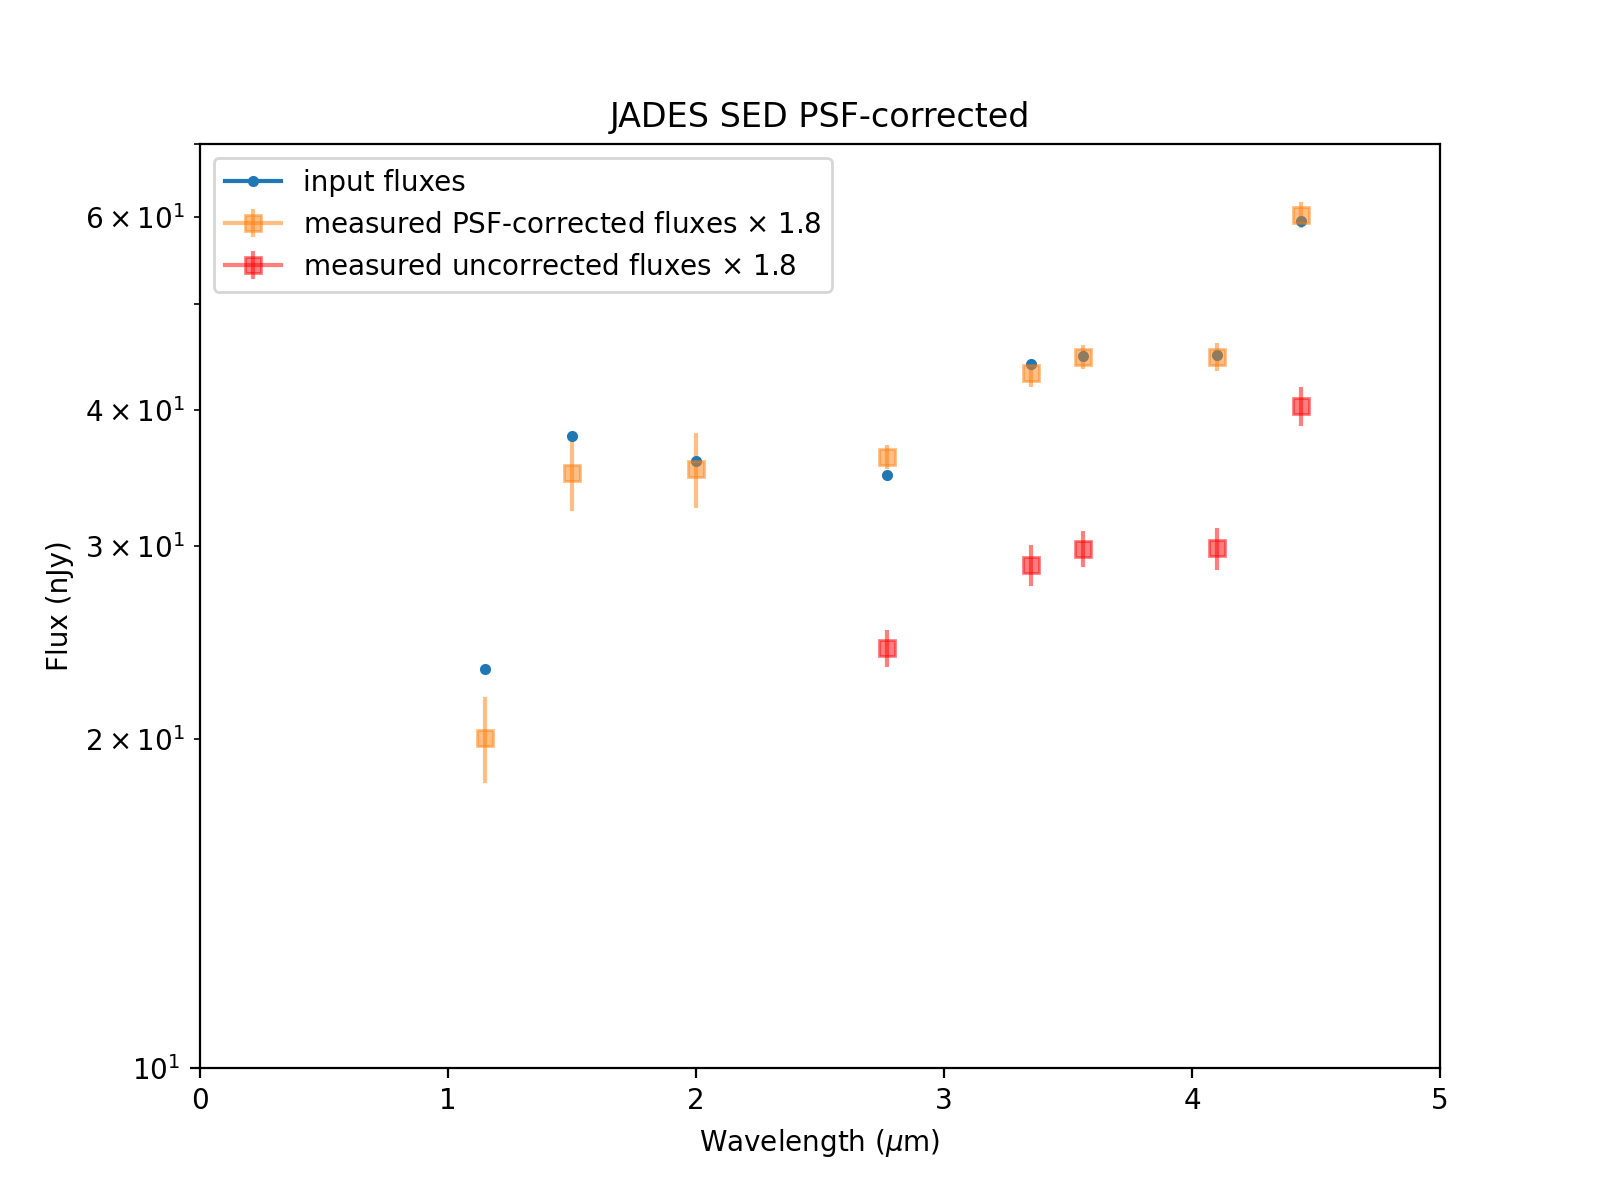

Text(0.5, 1.0, 'JADES SED PSF-corrected')

In [42]:
# Select by ID number
id = 261 # F090W dropout
input_obj  = simcropcat[idx][id-1]
output_obj = tbl[id-1]

fig, ax = plt.subplots(figsize=(8,6))

flux_factor = 1 / flux_scale_factor
for i, filt in enumerate(filters):
    input_flux  = input_obj['NRC_%s_fnu'%filt]    
    output_flux = output_obj[filt+'_flux'].value
    output_flux_err = output_obj[filt+'_fluxerr'].value

    lam = int(filt[1:4]) / 100
    label=['input fluxes', None][i>0]
    plt.plot(lam, input_flux, marker='.', c=mpl_colors[0], label=label)
    label=['measured PSF-corrected fluxes $\\times$ %.1f' % flux_factor, None][i>0]
    plt.errorbar(lam, output_flux*flux_factor, output_flux_err*flux_factor, marker='s', c=mpl_colors[1], alpha=0.5, label=label)
    
    PSFcor_column = filt+'_flux_PSFcor'
    if PSFcor_column in list(output_obj.columns):
        output_flux_uncor = output_flux / output_obj[PSFcor_column]
        label=['measured uncorrected fluxes $\\times$ %.1f' % flux_factor, None][i>i_reference+1]
        plt.errorbar(lam, output_flux_uncor * flux_factor, output_flux_err*flux_factor, marker='s', c='r', alpha=0.5, label=label)

plt.axhline(0, c='k', ls=':')
plt.xlim(0,5)
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Flux (nJy)')
plt.ylim(10, 70)
plt.semilogy()
plt.legend()
plt.title('JADES SED PSF-corrected')
#plt.savefig('JADES photutils SED.png')